In [159]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [160]:
%config InlineBackend.figure_format = 'svg'
sns.set_style("darkgrid", {'axes.grid' : True})

# Скачиваем данные

In [161]:
df_train = pd.read_csv('./X_train.csv')
df_test = pd.read_csv('./X_test.csv')

df_target = pd.read_csv('./y_train.csv')
df_test_sample = pd.read_csv('./y_test_sample.csv')

In [162]:
df_train.head()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members
0,0.000000,56,0,0.504328,6823.894458,9,0,1,0,5.0
1,0.170659,45,1,2.405860,356.580765,5,0,0,0,0.0
2,0.342176,75,1,0.445066,20349.895825,9,0,3,0,0.0
3,0.046219,50,0,0.814508,2894.368968,12,0,1,0,3.0
4,0.679556,58,0,0.390311,24833.227614,15,0,4,0,2.0


# Feature generation

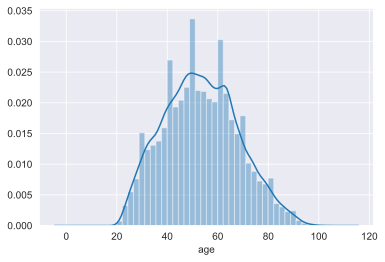

In [163]:
sns.distplot(df_train['age'])

In [164]:
df_train['age_40-60'] = 0
df_train.loc[(df_train['age'] > 40) & (df_train['age'] < 60), 'age_40-60'] = 1

In [165]:
df_train['monthly_income'] = np.log(df_train['monthly_income'])
df_test['monthly_income'] = np.log(df_test['monthly_income'])

In [166]:
df_train.loc[df_train['age'] > 100, ['age', 'credits_loans']]

,age,credits_loans
9611,101,15
21043,101,7
21090,102,2
40955,107,4
50761,101,6
80926,111,17
83789,107,10
89755,103,5
104532,102,8
104542,103,3


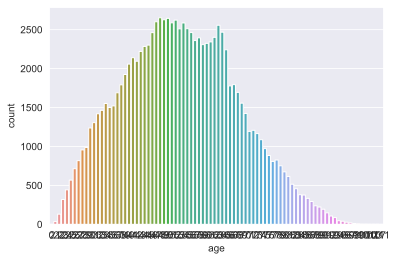

In [167]:
sns.countplot(df_train['age'])

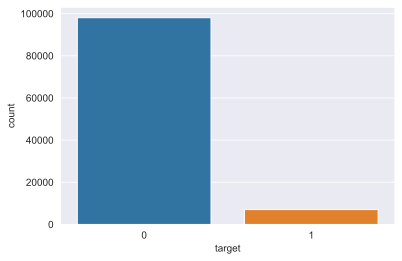

In [168]:
sns.countplot(df_target['target'])

In [169]:
df_train.head()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,age_40-60
0,0.000000,56,0,0.504328,8.828186,9,0,1,0,5.0,1
1,0.170659,45,1,2.405860,5.876561,5,0,0,0,0.0,1
2,0.342176,75,1,0.445066,9.920831,9,0,3,0,0.0,0
3,0.046219,50,0,0.814508,7.970522,12,0,1,0,3.0,1
4,0.679556,58,0,0.390311,10.119938,15,0,4,0,2.0,1


In [170]:
# Train
med_inc = df_train['monthly_income'].median()
med_fam = df_train['family_members'].median()
df_train['monthly_income'] = df_train['monthly_income'].fillna(med_inc)
df_train['family_members'] = df_train['family_members'].fillna(med_fam)
# Test
df_test['monthly_income'] = df_test['monthly_income'].fillna(df_test['monthly_income'].median())
df_test['family_members'] = df_test['family_members'].fillna(df_test['family_members'].median())

In [171]:
df_test.isna().sum()

index                         0
credit_card_utilization       0
age                           0
overdue_30_59_days            0
debt_to_income                0
monthly_income                0
credits_loans                 0
overdue__more_than_90_days    0
mortgage_loans                0
overdue_60_89_days            0
family_members                0
dtype: int64

In [172]:
df_test.shape

(38876, 11)

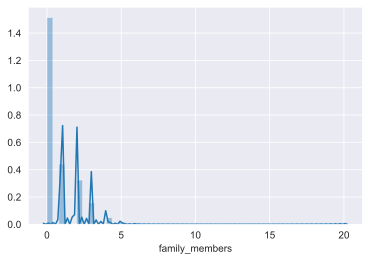

In [173]:
sns.distplot(df_train['family_members'].dropna())

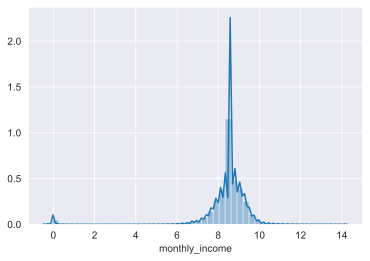

In [174]:
df_train.replace([np.inf, -np.inf], 0, inplace=True)
df_test.replace([np.inf, -np.inf], 0, inplace=True)
sns.distplot(df_train['monthly_income'])

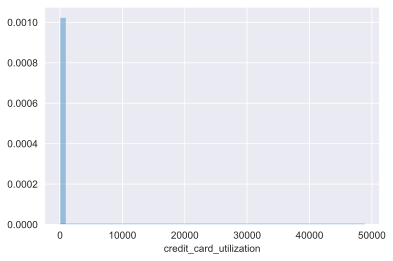

In [175]:
sns.distplot(df_train['credit_card_utilization'])

# Fit simple model

In [176]:
from sklearn.model_selection import train_test_split

In [177]:
X_train, X_test, y_train, y_test = train_test_split(df_train, df_target, test_size=0.3, random_state=17)

In [178]:
df_train.shape[0] == X_train.shape[0] + X_test.shape[0]

True

In [179]:
df_train.shape

(105109, 11)

### Decision Tree

In [180]:
from sklearn.tree import DecisionTreeClassifier

In [181]:
tree = DecisionTreeClassifier(random_state=17, max_depth=5)

In [182]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [183]:
y_pred = tree.predict(X_test)
y_pred_prob = tree.predict_proba(X_test)[:, 1]

In [184]:
y_pred_prob

array([0.01226494, 0.01226494, 0.01226494, ..., 0.01226494, 0.01226494,
       0.04041691])

In [185]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [186]:
print(accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred_prob))

0.9365109567754416 0.8407761578840012


In [187]:
df_target['target'].value_counts() #несбалансированность

0    98078
1     7031
Name: target, dtype: int64

### Better to simplify names of variables

In [188]:
X = df_train
y = df_target

### Make cross validation

In [189]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

#### Without strat

In [190]:
cross_val = cross_val_score(tree, X, y, cv=5, n_jobs=4, scoring='roc_auc')

In [191]:
cross_val.mean(), cross_val.std()

(0.8402808838060768, 0.008244573324829422)

#### With

In [192]:
cv = StratifiedKFold(n_splits=5, shuffle=True)
cross_val_strat = cross_val_score(tree, X, y, cv=cv, n_jobs=4, scoring='roc_auc')

In [193]:
cross_val_strat.mean(), cross_val_strat.std()

(0.8409791169300224, 0.005931048702114543)

#### Feature importance

In [194]:
%%time
for i in range(len(X.columns)):
    print('{0}: {1}'.format(X.columns[i], (tree.feature_importances_[i] * 100).round(4)))

credit_card_utilization: 13.6165
age: 1.3381
overdue_30_59_days: 9.9469
debt_to_income: 0.5722
monthly_income: 0.0
credits_loans: 0.1307
overdue__more_than_90_days: 61.4256
mortgage_loans: 0.0
overdue_60_89_days: 12.9701
family_members: 0.0
age_40-60: 0.0
Wall time: 0 ns


# Random Forest

In [195]:
from sklearn.ensemble import RandomForestClassifier

In [196]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=17)

In [197]:
rf_score = cross_val_score(rf, X, y, scoring='roc_auc', cv=5, n_jobs=4, verbose=1)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   17.3s finished


In [198]:
rf_score.mean(), rf_score.std()

(0.858025778118497, 0.006023633874690566)

#### fit

In [199]:
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)[:, 1]

print(accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred_prob))

0.9357498493641582 0.8573825410476578


In [200]:
for i in range(len(X.columns)):
    print('{0}: {1}'.format(X.columns[i], (rf.feature_importances_[i] * 100).round(4)))

credit_card_utilization: 18.6705
age: 1.7538
overdue_30_59_days: 15.19
debt_to_income: 1.0392
monthly_income: 0.9412
credits_loans: 1.3974
overdue__more_than_90_days: 36.8778
mortgage_loans: 0.679
overdue_60_89_days: 23.101
family_members: 0.2915
age_40-60: 0.0585


In [201]:
cross_val

array([0.8360139 , 0.8564284 , 0.8393601 , 0.83487046, 0.83473156])

# Grid Search for RF

In [202]:
from sklearn.model_selection import GridSearchCV

In [203]:
param_rf = {'max_depth': [3, 5, 7, 9, 10]}#, 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [10, 12]}

In [204]:
rf_grid = GridSearchCV(rf, param_rf, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)

In [205]:
%%time
rf_grid.fit(X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.7min finished


Wall time: 1min 56s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=17, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7, 9, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=1)

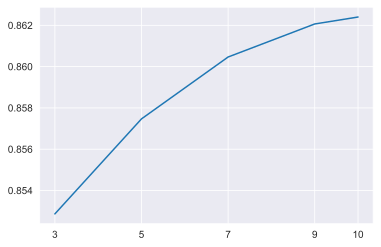

In [206]:
sns.lineplot(x = param_rf['max_depth'], y = rf_grid.cv_results_['mean_test_score'])
plt.xticks(param_rf['max_depth']);

In [207]:
rf_grid.best_params_

{'max_depth': 10}

In [208]:
rf_grid.best_score_

0.8624034675290114

# Save and predict best model

In [209]:
rf_best = rf_grid.best_estimator_

In [210]:
rf_best.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [211]:
predictions = rf_best.predict_proba(df_test.iloc[:, :])

In [212]:
predictions[:, 1]

array([0.536773  , 0.54089567, 0.56538699, ..., 0.57179058, 0.52691573,
       0.49463399])

In [213]:
df_test_sample['target'] = predictions[:, 1]

In [214]:
df_test_sample.to_csv('2_submit_rf.csv', index=False)

In [215]:
!head second_submit_rf.csv

index,target
143522,0.013317156966432708
116747,0.017284827381245402
66075,0.07530312114370362
133292,0.0230079121211193
83134,0.01834661431284513
127778,0.08921955521665016
53924,0.02277526275179729
19361,0.012324864427542477
43507,0.02786241788459969


# Feature distribution 

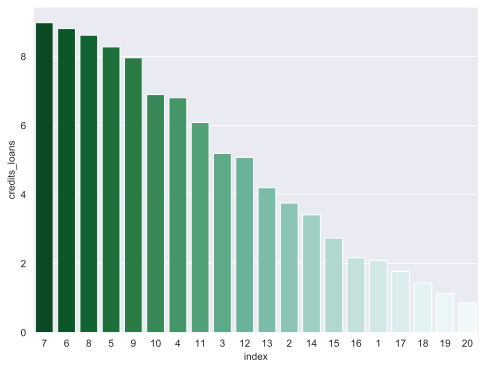

In [216]:
plt.figure(figsize=(8,6))
per = 'credits_loans' #ENTER YOUR FEATURE
a = pd.DataFrame(X[per].value_counts(normalize=True) * 100).head(20).reset_index()
a['index'] = a['index'].astype('int')
#a['index'] = a['index'].astype('str')
ax = sns.barplot(data=a, x='index', y=per, palette="BuGn_r", order=a['index'].tolist())
ax.set_xticklabels(ax.get_xticklabels(),rotation=0);

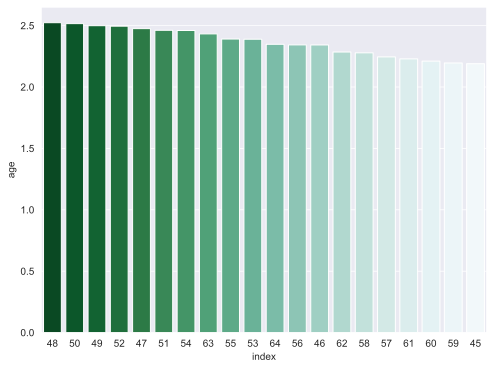

In [217]:
plt.figure(figsize=(8,6))
per = 'age'
a = pd.DataFrame(X[per].value_counts(normalize=True) * 100).head(20).reset_index()
a['index'] = a['index'].astype('int')
#a['index'] = a['index'].astype('str')
ax = sns.barplot(data=a, x='index', y=per, palette="BuGn_r", order=a['index'].tolist())
ax.set_xticklabels(ax.get_xticklabels(),rotation=0);

# CatBoost

In [218]:
from catboost import CatBoostClassifier

In [219]:
cat_features = ['age', 'overdue_30_59_days', 'credits_loans', 'overdue__more_than_90_days',
                'mortgage_loans', 'overdue_60_89_days', 'age_40-60']

In [220]:
X.head()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,age_40-60
0,0.000000,56,0,0.504328,8.828186,9,0,1,0,5.0,1
1,0.170659,45,1,2.405860,5.876561,5,0,0,0,0.0,1
2,0.342176,75,1,0.445066,9.920831,9,0,3,0,0.0,0
3,0.046219,50,0,0.814508,7.970522,12,0,1,0,3.0,1
4,0.679556,58,0,0.390311,10.119938,15,0,4,0,2.0,1


In [221]:
ctb = CatBoostClassifier(random_state=17, silent=True, eval_metric='AUC')

In [224]:
X_test.head()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,age_40-60
96853,0.049552,51,0,0.192911,8.794799,6,0,1,0,0.0,1
103007,0.028476,66,0,0.378592,9.891265,25,0,4,0,1.0,0
73900,0.025025,79,0,0.309715,8.309555,14,0,1,0,0.0,0
83836,0.592182,41,0,0.065468,7.699536,6,0,0,0,2.0,1
9680,0.001755,63,0,0.383056,9.148166,10,0,2,0,1.0,0


In [225]:
%%time
ctb.fit(X_train[cat_features], y_train, cat_features=cat_features)

AttributeError: module 'pandas' has no attribute 'SparseDtype'

In [147]:
ctb.predict_proba(X_test)[:, 1]

CatBoostError: There is no trained model to use predict_proba(). Use fit() to train model. Then use this method.

In [144]:
%%time
ctb.fit(X_train, y_train, cat_features=cat_features)
y_pred = ctb.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_pred))

AttributeError: module 'pandas' has no attribute 'SparseDtype'

In [ ]:
for i in range(len(X.columns)):
    print('{0}: {1}'.format(X.columns[i], (ctb.feature_importances_[i]).round(2)))

# CatBoost GridSearch

In [68]:
params = {'learning_rate': [0.1]}

grid_search_result = ctb.grid_search(params, X, y, verbose=1)

AttributeError: module 'pandas' has no attribute 'SparseDtype'

In [ ]:
grid_search_result['test']

In [ ]:
sns.lineplot(x = params['learning_rate'], y = [0.8569261, 0.8693249, 0.8698993])
plt.xticks(params['learning_rate']);
#plt.yticks([0.8569261, 0.8693249, 0.8698993]);

# Save

In [ ]:
# write your model
ctb_predictions = ctb.predict_proba(df_test.iloc[:, 1:])
df_test_sample['target'] = ctb_predictions[:, 1]
df_test_sample.to_csv('third_submit_ctb.csv', index=False)

In [ ]:
!head third_submit_ctb.csv

In [ ]:
X.columns